<a href="https://colab.research.google.com/github/MSaber9/Thesis2021/blob/main/Anomaly_detection_minmax_scaling2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!ls

sample_data


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import pickle
from glob import iglob

from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from keras.models import Model, load_model, Sequential
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
#df_bening = pd.read_csv('bengin_traffic.csv')

df_bening = pd.concat((pd.read_csv(f) for f in iglob('/content/drive/My Drive/Colab Notebooks/DataIoT/1.benign.csv' , recursive= True)), ignore_index=True)


In [8]:
df_bening.shape

(49548, 115)

There should have been 49,548 instances

In [ ]:
#df_bening = (df_bening - df_bening.mean()) / df_bening.std()
#df_bening = scale(df_bening)

In [9]:
scaler = MinMaxScaler()
df_bening = scaler.fit_transform(df_bening)

In [11]:
x_train, x_opt, x_test = np.split(df_bening, [int((1/3)*len(df_bening)), int((2/3)*len(df_bening))])

In [12]:
print(x_train.shape)
print(x_opt.shape)
print(x_test.shape)

(16516, 115)
(16516, 115)
(16516, 115)


In [14]:
nb_epoch = 800
input_dim = x_train.shape[1]
learning_rate = 0.012

autoencoder = Sequential()
autoencoder.add(Dense(int(0.75 * input_dim), activation="tanh", input_dim=input_dim))
autoencoder.add(Dense(int(0.5 * input_dim), activation="tanh"))
autoencoder.add(Dense(int(0.33 * input_dim), activation="tanh"))
autoencoder.add(Dense(int(0.25 * input_dim), activation="tanh"))
autoencoder.add(Dense(int(0.33 * input_dim), activation="tanh"))
autoencoder.add(Dense(int(0.5 * input_dim), activation="tanh"))
autoencoder.add(Dense(int(0.75 * input_dim), activation="tanh"))
autoencoder.add(Dense(input_dim))

In [15]:
autoencoder.compile(loss='mean_squared_error',
                    optimizer='sgd')

cp = ModelCheckpoint(filepath="autoencoder_traffic_minmax.h5",
                               save_best_only=True,
                               verbose=0)

tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

history = autoencoder.fit(x_train, x_train,
                    epochs=nb_epoch,
                    validation_data=(x_opt, x_opt),
                    verbose=1,
                    callbacks=[cp, tb]).history

Epoch 1/800
517/517 [==============================] - 2s 3ms/step - loss: 0.0441 - val_loss: 0.0245
Epoch 2/800
517/517 [==============================] - 1s 2ms/step - loss: 0.0219 - val_loss: 0.0146
Epoch 3/800
517/517 [==============================] - 1s 2ms/step - loss: 0.0133 - val_loss: 0.0092
Epoch 4/800
517/517 [==============================] - 1s 2ms/step - loss: 0.0086 - val_loss: 0.0065
Epoch 5/800
517/517 [==============================] - 1s 2ms/step - loss: 0.0063 - val_loss: 0.0052
Epoch 6/800
517/517 [==============================] - 1s 2ms/step - loss: 0.0051 - val_loss: 0.0046
Epoch 7/800
517/517 [==============================] - 1s 2ms/step - loss: 0.0048 - val_loss: 0.0042
Epoch 8/800
517/517 [==============================] - 1s 2ms/step - loss: 0.0045 - val_loss: 0.0041
Epoch 9/800
517/517 [==============================] - 1s 2ms/step - loss: 0.0042 - val_loss: 0.0040
Epoch 10/800
517/517 [==============================] - 1s 2ms/step - loss: 0.0041 - val_lo

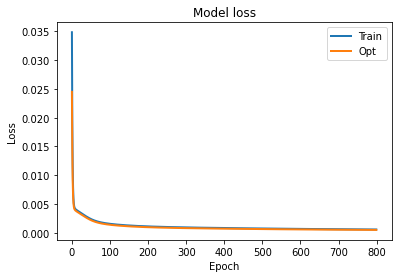

In [16]:
plt.plot(history['loss'], linewidth=2, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='Opt')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [17]:
x_opt_predictions = autoencoder.predict(x_opt)

In [18]:
mse = np.mean(np.power(x_opt - x_opt_predictions, 2), axis=1)

In [19]:
mse.shape

(16516,)

In [20]:
mse

array([5.88018255e-04, 8.47336959e-05, 7.13020133e-05, ...,
       4.55603416e-05, 2.19287329e-05, 4.46284705e-04])

In [21]:
print(mse.mean())
print(mse.min())
print(mse.max())
print(mse.std())

0.0004982144333734838
4.072174579022387e-06
0.1259072881771724
0.0036711736714630295


In [22]:
tr = mse.mean() + mse.std()
tr

0.004169388104836513

Claimed tr for this dataset is 0.042

In [23]:
x_test_predictions = autoencoder.predict(x_test)

In [24]:
mse_test = np.mean(np.power(x_test - x_test_predictions, 2), axis=1)
mse_test.shape

(16516,)

In [25]:
over_tr = mse_test > tr
false_positives = sum(over_tr)
print(false_positives)
fpr = false_positives / mse_test.shape[0]
print(fpr)

251
0.01519738435456527


Claimed window size is 82

In [26]:
def alarms_with_window(w, over_tr):
  false_alarms = 0
  for i in range(0, len(over_tr) - w):
    fp = sum(over_tr[i:i+w])
    if fp/2 > w:
      false_alarms = false_alarms + 1
  return false_alarms

In [27]:
print('False alarms with window %d : %d' % (82, alarms_with_window(82, over_tr)))
print('False alarms with window %d : %d' % (20, alarms_with_window(20, over_tr)))


False alarms with window 82 : 0
False alarms with window 20 : 0
